# Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when submit. The list of files:
- This notebook
- assignment1_modules.ipynb
- assignment0_differentiation.ipynb

In [1]:
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib

%matplotlib inline

matplotlib.style.use('ggplot')

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
% run assignment1_modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):

            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            cur_old_grad = config['momentum'] * cur_old_grad + config['learning_rate'] * cur_dx
            
            if cur_old_grad.shape[0] == 1:
                cur_x = cur_x.reshape(cur_old_grad.shape)
            
            np.add(cur_x, -cur_old_grad, out=cur_x)
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

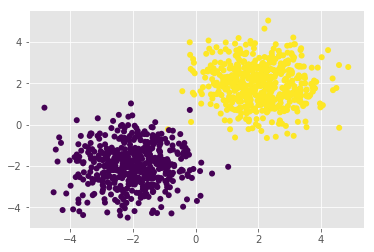

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
criterion = ClassNLLCriterion()

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(SoftMax())

print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

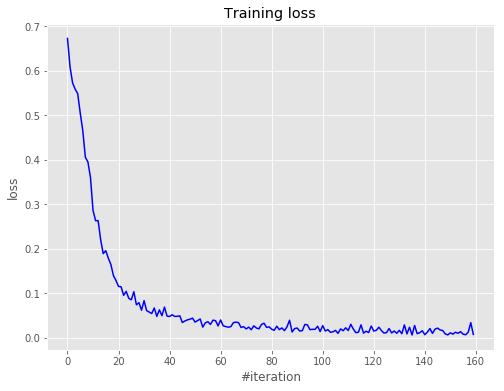

Current loss: 0.007771


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches(X, Y, batch_size):
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [9]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [10]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
one_hot_y = enc.fit_transform(y.reshape(-1, 1)).todense()
y = np.array(one_hot_y)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchMeanSubtraction` between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchMeanSubtraction` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Hint: logloss for MNIST should be around 0.5. 

In [11]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=10000)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=5000)

/Users/Helen/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Accuracy

In [12]:
def accuracy(y_pred, y_true):
    acc = 0
    for pred, true in zip(y_pred, y_true):
        acc = acc+(np.argmax(pred)==np.argmax(true))
    return acc/len(y_true)*100

# Train

In [55]:
def net_train(X_train, Y_train, net, criterion, n_epoch, batch_size):
    optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
    optimizer_state = {}
    net.training = True
    loss_history = []
    for i in range(n_epoch):
        loss_batch = []
        for x_batch, y_batch in get_batches(X_train, Y_train, batch_size):
            net.zeroGradParameters()
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            # Backward

            dp = criterion.backward(predictions, y_batch)

            net.backward(x_batch, dp)

            # Update weights
            sgd_momentum(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)

            loss_batch.append(loss)

        loss_history.append(np.mean(loss_batch))

        # Visualize

        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, label = str(net) + "Current loss: " + str(loss))
        plt.legend()        
        plt.show()

# ReLU

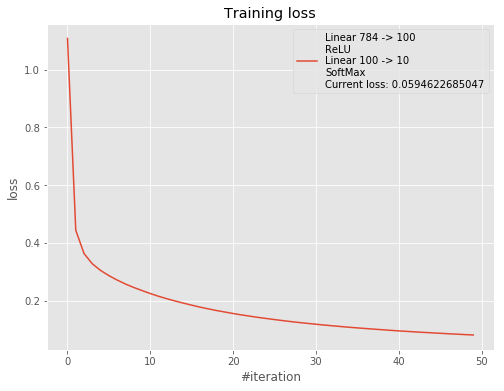

In [56]:
criterion = ClassNLLCriterion()
net = Sequential()
net.add(Linear(784, 100))
net.add(ReLU())
net.add(Linear(100,10))
net.add(SoftMax())

net_train(X_train, Y_train, net, criterion, 50, 500)

In [57]:
print(net)
net.evaluate()
print("test accuracy {}%".format(accuracy(net.forward(X_test), Y_test)))
print("train accuracy {}%".format(accuracy(net.forward(X_train), Y_train)))

Linear 784 -> 100
ReLU
Linear 100 -> 10
SoftMax

test accuracy 97.06%
train accuracy 97.85333333333334%


# LeakyReLU

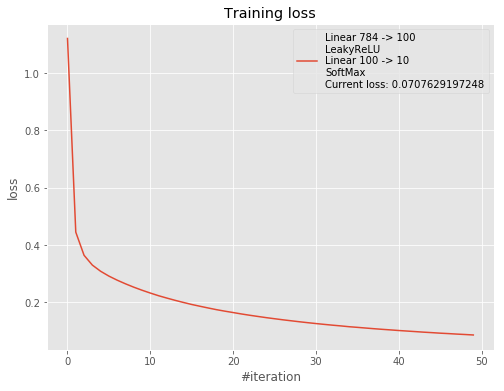

In [58]:
criterion = ClassNLLCriterion()
net = Sequential()
net.add(Linear(784, 100))
net.add(LeakyReLU())
net.add(Linear(100, 10))
net.add(SoftMax())

net_train(X_train, Y_train, net, criterion, 50, 500)

In [59]:
print(net)
net.evaluate()
print("test accuracy {}%".format(accuracy(net.forward(X_test), Y_test)))
print("train accuracy {}%".format(accuracy(net.forward(X_train), Y_train)))

Linear 784 -> 100
LeakyReLU
Linear 100 -> 10
SoftMax

test accuracy 96.88%
train accuracy 97.66666666666667%


# SoftPlus

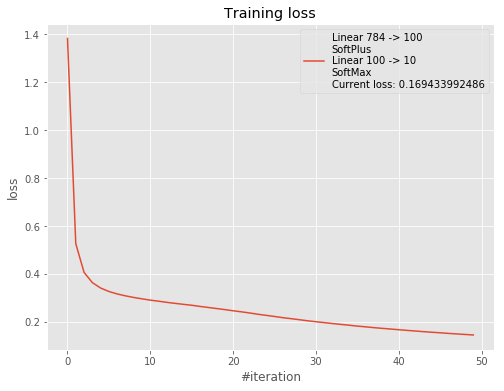

In [60]:
criterion = ClassNLLCriterion()
net = Sequential()
net.add(Linear(784, 100))
net.add(SoftPlus())
net.add(Linear(100, 10))
net.add(SoftMax())

net_train(X_train, Y_train, net, criterion, 50, 500)

In [61]:
print(net)
net.evaluate()
print("test accuracy {}%".format(accuracy(net.forward(X_test), Y_test)))
print("train accuracy {}%".format(accuracy(net.forward(X_train), Y_train)))

Linear 784 -> 100
SoftPlus
Linear 100 -> 10
SoftMax

test accuracy 95.6%
train accuracy 95.93166666666667%


# ELU

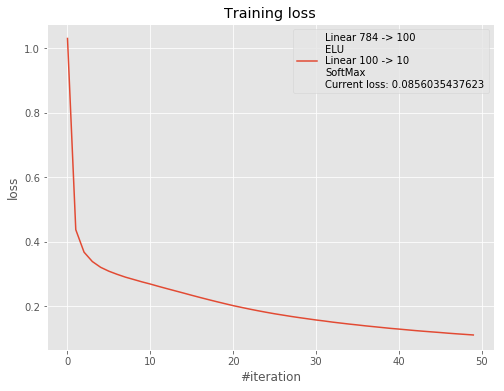

In [62]:
criterion = ClassNLLCriterion()
net = Sequential()
net.add(Linear(784, 100))
net.add(ELU())
net.add(Linear(100, 10))
net.add(SoftMax())

net_train(X_train, Y_train, net, criterion, 50, 500)

In [63]:
print(net)
net.evaluate()
print("test accuracy {}%".format(accuracy(net.forward(X_test), Y_test)))
print("train accuracy {}%".format(accuracy(net.forward(X_train), Y_train)))

Linear 784 -> 100
ELU
Linear 100 -> 10
SoftMax

test accuracy 96.39999999999999%
train accuracy 96.92333333333333%
